<a href="https://colab.research.google.com/github/aRod209/pytorch-for-deep-learning/blob/main/02_pytorch_classification_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

Book version of this notebook - https://www.learnpytorch.io/02_pytorch_classification/

All other resources - https://github.com/mrdbourke/pytorch-deep-learning

Stuck? Ask a question - https://github.com/mrdbourke/pytorch-deep-learning/discussions

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 100 smaples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f'First 5 samples of X: {X[:5]}')
print(f'First 5 samples of y: {y[:5]}')

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [5]:
# Make a DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'label': y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


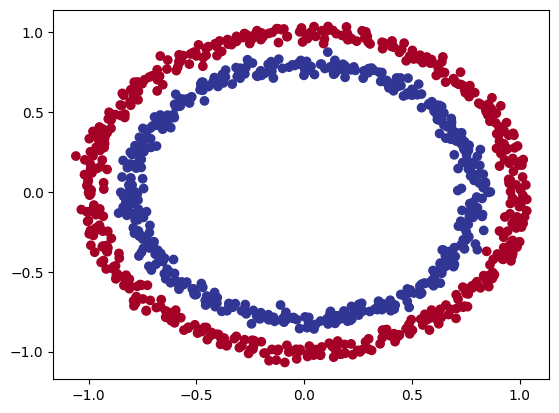

In [6]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enought to experiment but still sizeable enough to practice fundamentals.

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# View the first example of features and lables
X_sample = X[0]
y_sample = y[0]

print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and crate train and test splits

In [10]:
import torch
torch.__version__

'2.1.0+cu118'

In [11]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [12]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an anccellerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [16]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [18]:
X_train.shape

torch.Size([800, 2])

Now we've setup device agnostic code, let's create a model that

1. Sublcass `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [19]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 fetures and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x => layer_1 => layer_2 => output

In [20]:
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [22]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3899,  0.2053],
                      [ 0.2731, -0.0288],
                      [ 0.3829, -0.2495],
                      [ 0.1257,  0.1301],
                      [ 0.4758, -0.1215]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6936,  0.2598,  0.5337,  0.0902, -0.0451], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3616, -0.0481, -0.3001,  0.3361, -0.0711]], device='cuda:0')),
             ('1.bias', tensor([0.2222], device='cuda:0'))])

In [24]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print(f'Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Length of test samples: {len(X_test)}, Shape: {X_test.shape}')
print(f'\nFirst 10 predictions:\n{untrained_preds[:10]}')
print(f'\nFirst 10 labels:\n{y_test[:10]}')

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[ 0.0685],
        [ 0.0230],
        [-0.0484],
        [ 0.1027],
        [-0.4235],
        [-0.4483],
        [-0.2792],
        [-0.3906],
        [-0.0324],
        [ 0.0158]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression you might want want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder , the loss function measures how wrong your model's predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For some common choices of loss functions and optimizers - https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

* For a definition of what a logit is in deep learning - https://stackoverflow.com/a/52111173

* For different optimizers see `torch.optim`

In [25]:
# Setup the loss function
#loss_fn = nn.BCELoss() # requires inputs to have gone through the sigmoid activation function prior to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogits = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [26]:
# Calculate accuracy - out of 100 examles, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train Model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary crossentropy and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [27]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0685],
        [ 0.0230],
        [-0.0484],
        [ 0.1027],
        [-0.4235]], device='cuda:0')

In [28]:
y_test[:5] # above not in same format as test labels

tensor([1., 0., 1., 0., 1.])

In [29]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5171],
        [0.5058],
        [0.4879],
        [0.5256],
        [0.3957]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5 `y=0` (class 0)

In [30]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)
y_preds

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.]], device='cuda:0')

In [31]:
# In full (logits -> pred probs -> pred labels)
model_0.eval()
with torch.inference_mode():
  y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 0., 1., 0.], device='cuda:0')

### 3.2 Building a training and test loop

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred_prob = torch.sigmoid(y_logits) # logits -> pred probs
  y_pred = torch.round(torch.sigmoid(y_logits)) # pred probs -> pred labels

  # 2. Calculate loss/accuracy
  #loss = loss_fn(y_pred_prob, y_train) # nn.BCELoss expects prediction probabilities
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 10 == 0:
      print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.70195, Acc: 48.25% | Test loss: 0.70220, Test acc: 44.50%
Epoch: 10 | Loss: 0.69771, Acc: 49.62% | Test loss: 0.69886, Test acc: 46.50%
Epoch: 20 | Loss: 0.69610, Acc: 49.38% | Test loss: 0.69764, Test acc: 50.00%
Epoch: 30 | Loss: 0.69535, Acc: 49.50% | Test loss: 0.69710, Test acc: 51.50%
Epoch: 40 | Loss: 0.69492, Acc: 49.50% | Test loss: 0.69679, Test acc: 51.50%
Epoch: 50 | Loss: 0.69462, Acc: 50.00% | Test loss: 0.69657, Test acc: 50.50%
Epoch: 60 | Loss: 0.69439, Acc: 50.62% | Test loss: 0.69639, Test acc: 51.00%
Epoch: 70 | Loss: 0.69420, Acc: 50.50% | Test loss: 0.69624, Test acc: 50.50%
Epoch: 80 | Loss: 0.69403, Acc: 50.38% | Test loss: 0.69611, Test acc: 49.00%
Epoch: 90 | Loss: 0.69390, Acc: 50.75% | Test loss: 0.69600, Test acc: 49.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize!"

To do so, we're going to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [33]:
import requests
from pathlib import Path
# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists, skipping download')
else:
  print('Download helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')

  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

Download helper_functions.py


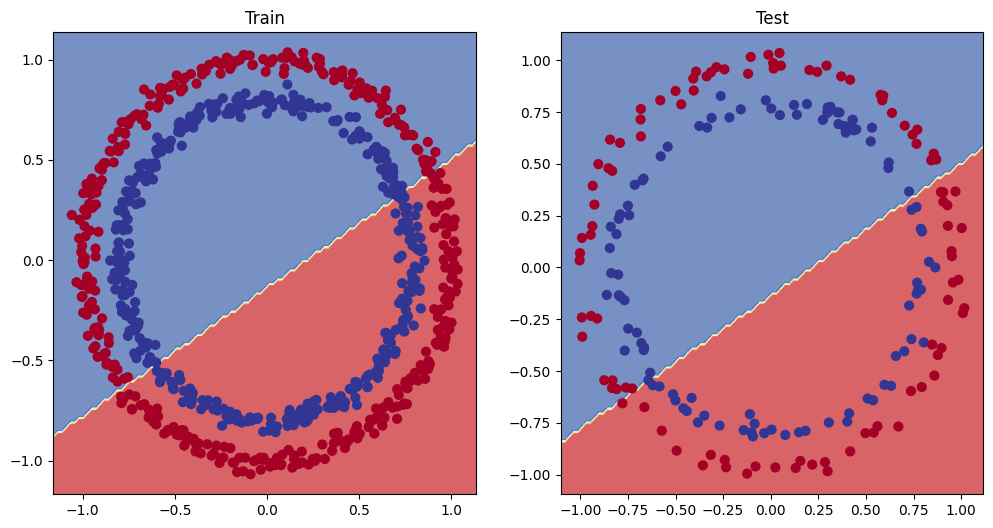

In [34]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model persective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from oru model's perspective because they deal directly with the model rather than the data.

And because these options are all values we (as machine learning engineers and data scientiests) can change, they are **hyperparameters**.

Let's try improving our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epcochs: 100 -> 1000

In [35]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    #z = self.layer_1(x)
    #z = self.layer_2(z)
    #z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed-ups wherever possible behind the scenes

In [36]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [37]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [38]:
# Write a training and evaluation loop mfor model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ## Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_prob = torch.sigmoid(y_logits)
  y_pred = torch.round(y_prob)

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zer grad
  optimizer. zero_grad

  # 4. Loss backward (back Propagation)
  loss.backward()

  # 5. Optiizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_prob = torch.sigmoid(test_logits)
    test_pred = torch.round(test_prob)

    # 2. Calculate loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 100 == 0:
      print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261 | Test acc: 51.00%
Epoch: 100 | Loss: 0.69307, Acc: 51.25% | Test loss: 0.69614 | Test acc: 46.50%
Epoch: 200 | Loss: 0.69301, Acc: 50.00% | Test loss: 0.69426 | Test acc: 47.00%
Epoch: 300 | Loss: 0.69316, Acc: 49.50% | Test loss: 0.69367 | Test acc: 51.50%
Epoch: 400 | Loss: 0.69306, Acc: 48.25% | Test loss: 0.69475 | Test acc: 46.50%
Epoch: 500 | Loss: 0.69316, Acc: 50.50% | Test loss: 0.69598 | Test acc: 47.00%
Epoch: 600 | Loss: 0.69335, Acc: 51.75% | Test loss: 0.69407 | Test acc: 52.50%
Epoch: 700 | Loss: 0.69333, Acc: 51.00% | Test loss: 0.69555 | Test acc: 49.00%
Epoch: 800 | Loss: 0.69325, Acc: 52.12% | Test loss: 0.69472 | Test acc: 50.00%
Epoch: 900 | Loss: 0.69347, Acc: 50.25% | Test loss: 0.69352 | Test acc: 49.50%


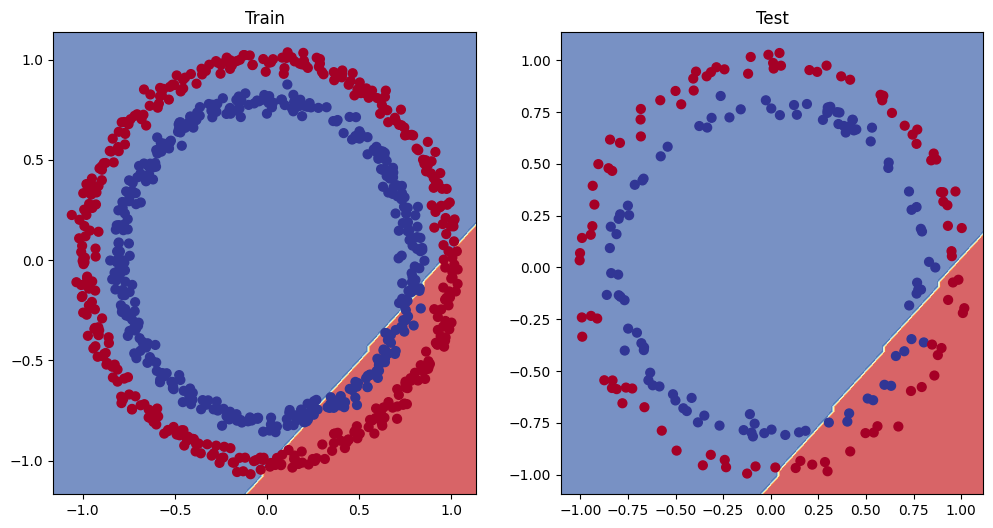

In [39]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem.

In [40]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [41]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

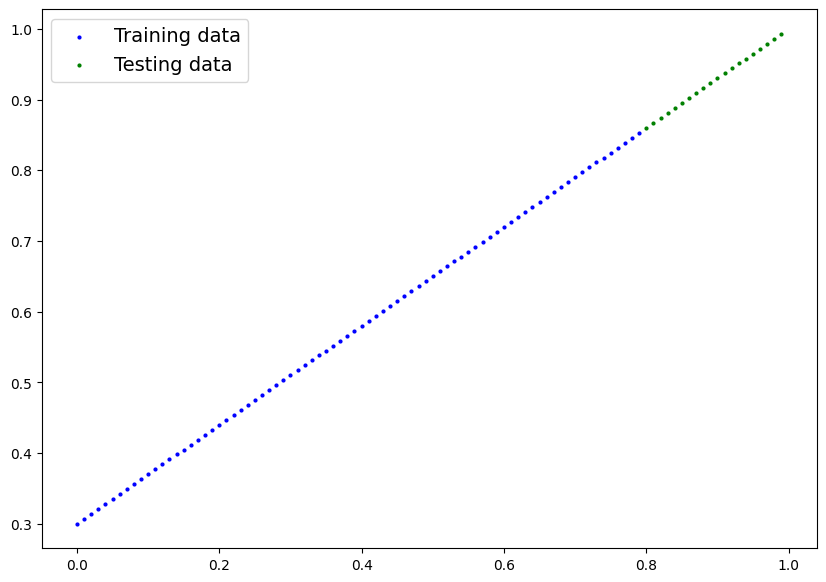

In [42]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1`  to fit a straight line

In [43]:
# Sam architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [44]:
# Loss and optimizer
loss_fn = nn.L1Loss() # MAE loss with regression data
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [45]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  model_2.train()
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}')

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 10 | Loss: 0.40240 | Test loss: 0.50474
Epoch: 20 | Loss: 0.06007 | Test loss: 0.10151
Epoch: 30 | Loss: 0.01559 | Test loss: 0.03231
Epoch: 40 | Loss: 0.03092 | Test loss: 0.00111
Epoch: 50 | Loss: 0.03196 | Test loss: 0.00108
Epoch: 60 | Loss: 0.03192 | Test loss: 0.00170
Epoch: 70 | Loss: 0.03081 | Test loss: 0.00097
Epoch: 80 | Loss: 0.03077 | Test loss: 0.00150
Epoch: 90 | Loss: 0.02967 | Test loss: 0.00092
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 110 | Loss: 0.02962 | Test loss: 0.00197
Epoch: 120 | Loss: 0.02748 | Test loss: 0.00091
Epoch: 130 | Loss: 0.02852 | Test loss: 0.00181
Epoch: 140 | Loss: 0.02850 | Test loss: 0.00246
Epoch: 150 | Loss: 0.02744 | Test loss: 0.00169
Epoch: 160 | Loss: 0.02638 | Test loss: 0.00123
Epoch: 170 | Loss: 0.02637 | Test loss: 0.00162
Epoch: 180 | Loss: 0.02532 | Test loss: 0.00125
Epoch: 190 | Loss: 0.02636 | Test loss: 0.00284
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epo

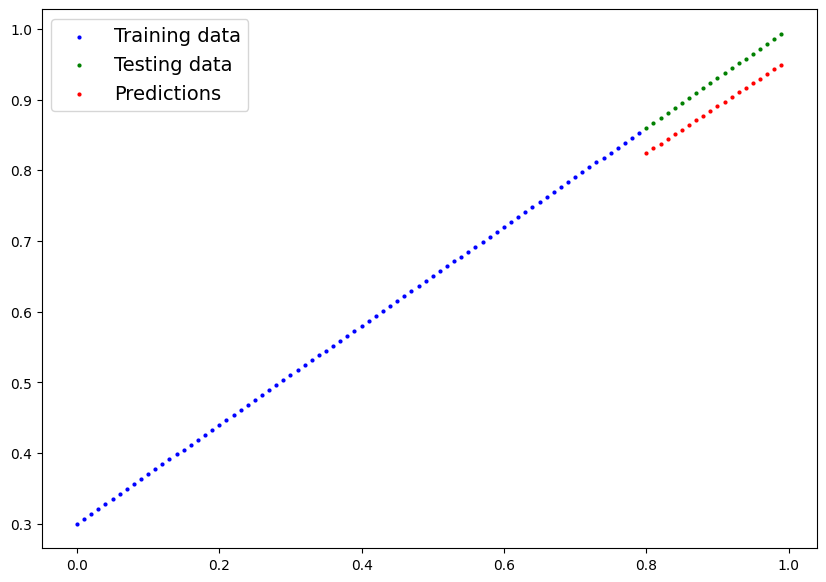

In [46]:
# Turn on evaluation mode
model_2.eval()

# make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. This missing piece: non-linearity

"What pattersn could yo draw if yo were given an infinite amount of straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

### #6.1 Recreating non-linear data (red and blue circles)

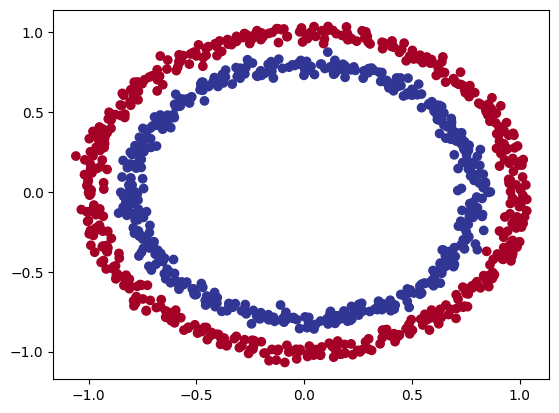

In [47]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [48]:
# Convert data to tensors and then to train and test split
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straight lines
* Non-Linear = non straight lines

Artificial neural networks are a large combination of linear (straight) and non-linear (non-straight) functions whith are potentially able to find patterns in data.

In [49]:
# Build a model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [50]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

### 6.3 Training a model with non-linearity

In [51]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 3000

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logtist -> prediction -> probabilities -> predictions

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first arg)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    y_test_logits = model_3(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))

    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=y_test_pred)

  # Print out what's happenin`
  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.6929 | Acc: 50.00% | Test loss: 0.6932 | Test Acc: 50.00%
Epoch: 100 | Loss: 0.6912 | Acc: 52.88% | Test loss: 0.6910 | Test Acc: 52.50%
Epoch: 200 | Loss: 0.6898 | Acc: 53.37% | Test loss: 0.6894 | Test Acc: 55.00%
Epoch: 300 | Loss: 0.6879 | Acc: 53.00% | Test loss: 0.6872 | Test Acc: 56.00%
Epoch: 400 | Loss: 0.6852 | Acc: 52.75% | Test loss: 0.6841 | Test Acc: 56.50%
Epoch: 500 | Loss: 0.6810 | Acc: 52.75% | Test loss: 0.6794 | Test Acc: 56.50%
Epoch: 600 | Loss: 0.6751 | Acc: 54.50% | Test loss: 0.6729 | Test Acc: 56.00%
Epoch: 700 | Loss: 0.6666 | Acc: 58.38% | Test loss: 0.6632 | Test Acc: 59.00%
Epoch: 800 | Loss: 0.6516 | Acc: 64.00% | Test loss: 0.6476 | Test Acc: 67.50%
Epoch: 900 | Loss: 0.6236 | Acc: 74.00% | Test loss: 0.6215 | Test Acc: 79.00%
Epoch: 1000 | Loss: 0.5682 | Acc: 87.75% | Test loss: 0.5738 | Test Acc: 86.50%
Epoch: 1100 | Loss: 0.4815 | Acc: 93.50% | Test loss: 0.4993 | Test Acc: 90.50%
Epoch: 1200 | Loss: 0.3706 | Acc: 97.75% | Test loss

### 6.4 Evaluating a model trained with non-linear activation functions

In [52]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

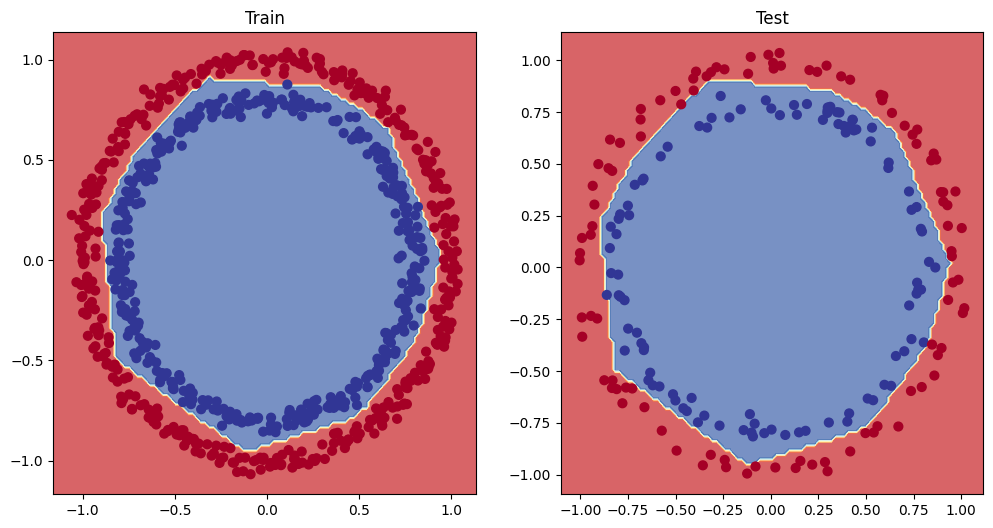

In [53]:
# Plot decision boundaries for model 3 (has non-linearity)
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)

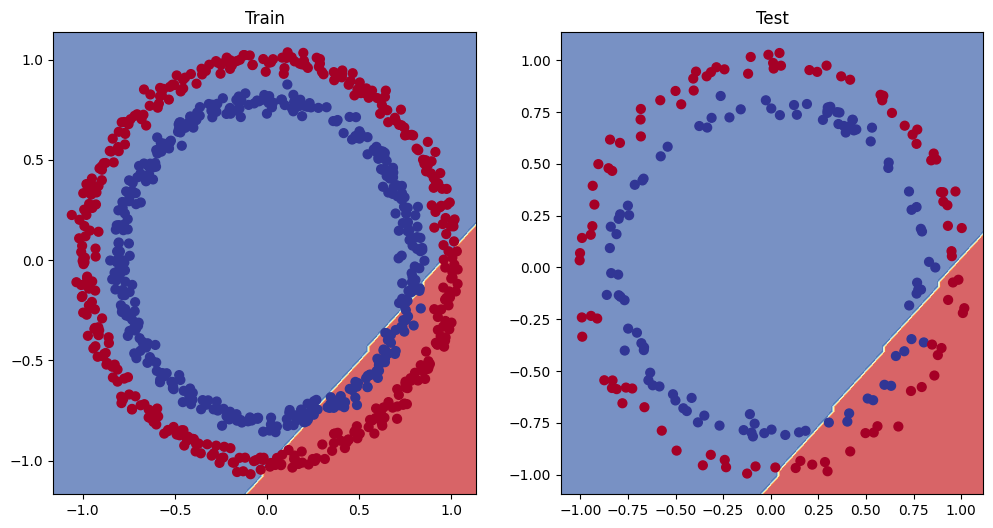

In [54]:
# Plot decision boundaries for model 1 (no non-linearity)
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

## 7. Replicating non-linear activation funcitons

Neural networks, ratther than us telling the model what to learn, we give it to the tools to discover patterns in data and it tries to figure out the best patterns on its own.

And these tools are linear and non-linear functions.

In [55]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [56]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

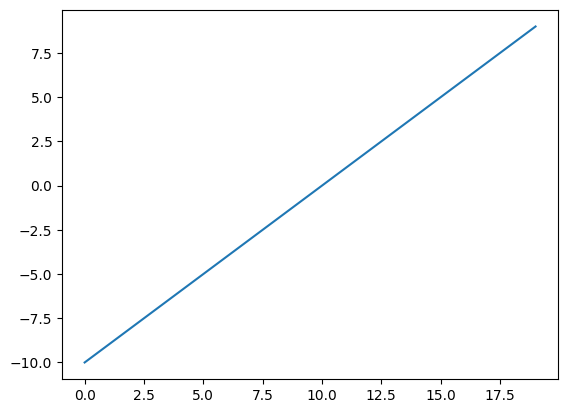

In [57]:
# Visualize the tensor
plt.plot(A)
plt.show()

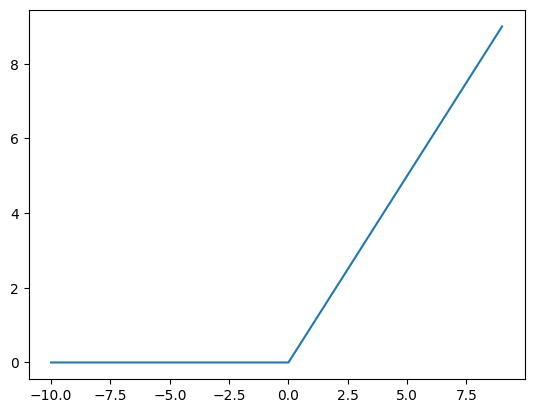

In [58]:
plt.plot(A, torch.relu(A))
plt.show()

In [59]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

In [60]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

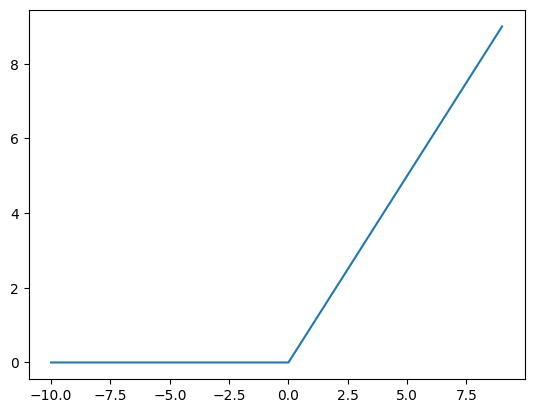

In [61]:
# Plot RLU activation function
plt.plot(A, relu(A))
plt.show()

In [62]:
# Now let's do the same for Sigmoid: https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

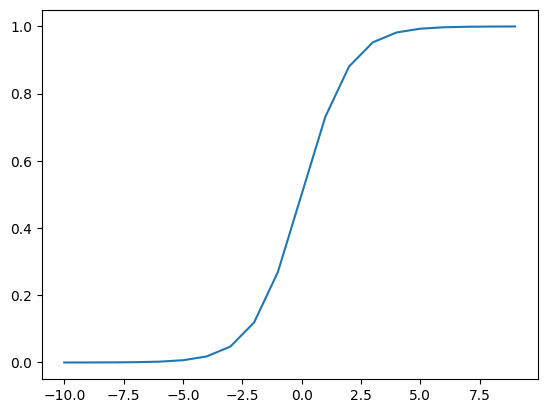

In [63]:
plt.plot(A, torch.sigmoid(A))

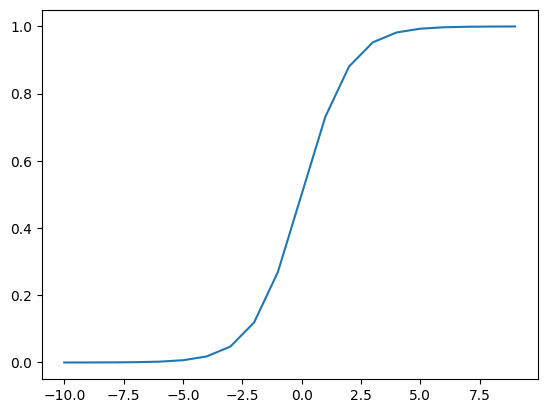

In [64]:
plt.plot(A, sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classificatoin = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multi-class classification = more then one ting or another (cat vs. dog vs. chicken)

In [65]:
### 8.1 Creating a toy multi-class dataset

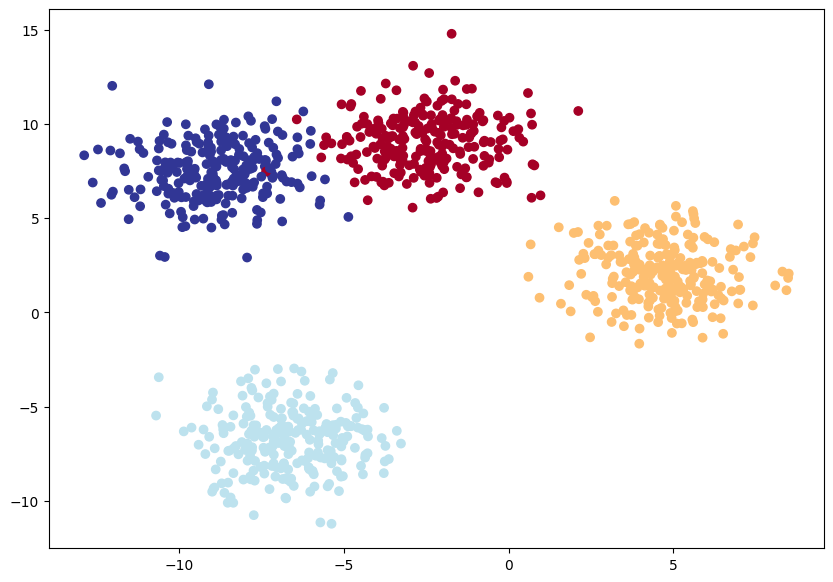

In [70]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_SAMPLES = 1000
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little cshakeup
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);